<a href="https://colab.research.google.com/github/chadi-aebi/DMML2021_Rolex/blob/main/code/Notebook_Rolex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> UNIL Team Rolex




In this notebook we will proceed as follows:

First we prepare the notebook by importing essential methods and components for text analytics. Then we will start with some preparations such as building a tokenizer with different possible features to apply this later in the classification.

Subsequently, we start the text analytics divided by the different classifiers starting with a baseline calculation.
Each classifier section starts with a classification without any data preprocessing or other features. Then we tune the hyperparameters for the classifier to find the best parameters. After that, we train models that also implement the preprocessing of data, we try word embeddings and in the end we try out dimensionality reduction and standardisation.

The notebook has the following chapters:



*   0.1.   Preparation to start working - impor necessary methods etc.
*   0.2.   Further preparation for classification


1.     Baseline calculation
2.     Logistic Regression
3.     kNN Classifier
4.     Decision Tree
5.     Random Forests
6.     Linear Support Vector Classification




# 0.1 Preparation to start working - import necessary methods etc.

In [150]:
#Install and update spacy
!pip install -U spacy
#Download the french language model
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 17.4 MB 2.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
import csv
import time

In [152]:
#Classifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC

#Other
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from spacy import displacy
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr import French

# 0.2 Further preparations to starkt with classification

Set random_seed, Vectorizers without preprocessing and load the french language model



In [153]:
np.random_seed = 0

In [154]:
#Set TF-IDF and Count Vectorizer without any more specifications
tfidf_vector = TfidfVectorizer()
#count_vector = CountVectorizer()

#with preprocessing
#tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)


In [155]:
#Load the french language model
nlp = spacy.load('fr_core_news_sm')

In [156]:
#Import stop words from french language model and puncutations
stop_words=spacy.lang.fr.stop_words.STOP_WORDS
punctuations = string.punctuation

In [157]:
#Create a tokenizer function that can be used for preprocessing the data for classification - we try out different combinations of the sentence features

def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Remove stop words 
    #mytokens = [ word for word in mytokens if word not in stop_words]

    # Remove punctuation
    #mytokens = [ word for word in mytokens if word not in punctuations ]

    # Remove anonymous dates and people
    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""]]

    # Return preprocessed list of tokens
    return mytokens

We found that stopword removal did not lead to better results. This is well possible because by removing frequent and rather simple words you might remove the majority of words that appear in sentences of A1/A2 difficulty. Without those words it will be difficult to differentiate between sentences that are more sophisticated and those that only stay at a very basic level. 

In [158]:
#Function for model evaluation
def evaluate(true, pred):
    precision = precision_score(true, pred, average= 'macro')
    recall = recall_score(true, pred, average = 'macro')
    f1 = f1_score(true, pred, average = 'macro')
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")


 # Confusion Matrix

 # Evaluate model
def accuracy_conf_mat(y_test, y_pred):
  print(round(accuracy_score(y_test, y_pred), 4))
  labels = list(unique_labels(y_test, y_pred))
  conf_mat = confusion_matrix(y_test, y_pred, labels = labels)
  fig, ax = plt.subplots(figsize=(10,10))
  plt.title('Confusion matrix of the classifier')
  sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels = labels, yticklabels = labels)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()



 

<h1>  Getting started - text analytics per classifier


# 1. Baseline

First, we start by calculating the baseline.

In [159]:
data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
X = data['sentence']
ylabels = data['difficulty']
print(ylabels.value_counts(normalize=True))

A1    0.169375
C2    0.168125
C1    0.166250
B1    0.165625
A2    0.165625
B2    0.165000
Name: difficulty, dtype: float64


In [160]:
baseline = ylabels.value_counts(normalize = True).max()
baseline

0.169375

# 2. Logistic Regression
<h2> 2.1 Logistic Regression without any data cleaning or tuning

We load the data...

In [161]:
lr_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
lr_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')
lr_data.shape

(4800, 2)

In [162]:
lr_data.head()

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


..., select the features and train-test-split the data.

In [163]:
X_lr = lr_data['sentence']
ylabels_lr = lr_data['difficulty']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, ylabels_lr, test_size=0.2, random_state=0, stratify=ylabels_lr)

Then we define the classifier with its default settings...

In [164]:
# Define classifier
lreg = LogisticRegression()

... and create the pipeline with the Classifier and the TF-IDF vectorizer without tokenization. Then we fit the model to our training data...

In [165]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', lreg)])

# Fit model on training set
pipe.fit(X_train_lr, y_train_lr)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

... and make predicitions with this test data.

In [166]:
# Predictions
y_pred_lr = pipe.predict(X_test_lr)

acc_lr_0 = accuracy_score(y_test_lr,y_pred_lr)
evaluate(y_test_lr, y_pred_lr)


ACCURACY SCORE:
0.4604
CLASSIFICATION REPORT:
	Precision: 0.4578
	Recall: 0.4595
	F1_Score: 0.4554


0.4604


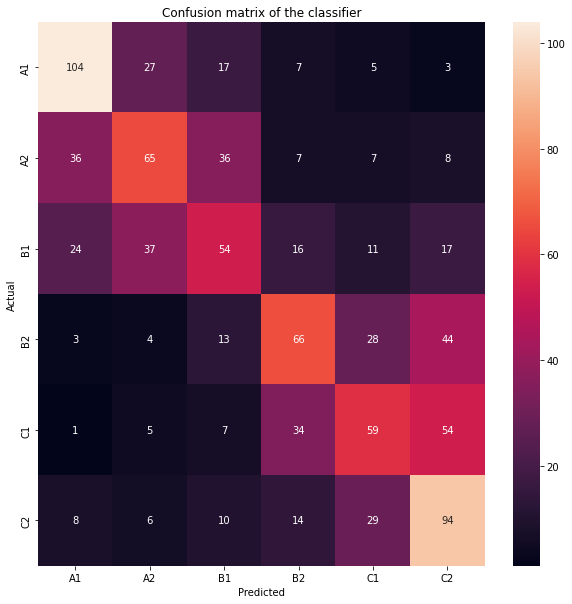

In [167]:
accuracy_conf_mat(y_test_lr, y_pred_lr)


This was a first model without any other features. Let's have a look at some wrong predictions to find some hints what could be improved.

In [168]:
df = pd.DataFrame(X_test_lr, columns=["sentence"])
df["actual"] = y_test_lr
df["predicted"] = y_pred_lr

incorrect = df[df["actual"] != df["predicted"]]
incorrect.head(20)

,sentence,actual,predicted
id,,,
2003,Il est également connu pour ses publicités tél...,C1,B2
2585,"Edgar, étincelant de furie, dominait tous les ...",C1,B2
2302,Ils sont heureux.,A1,B2
2958,Les canons renversèrent d'abord à peu près six...,C1,B2
3862,Parce que la philosophie se trouve de plus en ...,C1,C2
2429,Le gouvernement veut lutter contre la fraude d...,C2,C1
4230,"Près de la pagode Sule, dans le centre de Rang...",C1,C2
4347,Voilà qui serait en effet de nature à simplifi...,B2,C2
3909,"Les articulations sont en haut la hanche, au m...",B1,C1


In [169]:
#submission_test_lr = pd.DataFrame(y_pred_lr, columns=['difficulty'])
#submission_test_lr

In [170]:
#submission_test_lr.to_csv('submission_21-12-12.csv')

<h2> 2.2 Logistic Regression with hyperparameters tuning

In this section we searched for the best hyperparameters to improve our classifiers.

In [171]:
# Define parameters to test

#grid_lr = {
#    'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
#    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
#    #'max_iter': list(range(100,800,100)),
#    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#}

# Define and fit model

#lreg = LogisticRegression()
#lreg_cv = GridSearchCV(lreg, grid_lr, cv=10)
#pipe = Pipeline([('vectorizer', tfidf_vector),
 #                ('classifier', lreg_cv)])

#pipe.fit(X_train_lr, y_train_lr)

# Print results

#print("Hyperparameters:", lreg_cv.best_params_)
#y_pred_lr = pipe.predict(X_test_lr)
#evaluate(y_test_lr, y_pred_lr)

We saved the hyperparameters and use them for the following predictions.

In [172]:
#safe best parameters
#Hyperparameters= {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

<h2> 2.3 Logistic Regression with further methods 

<h3> 2.3.1 Preprocessing

In this section we extended the TF-IDF Vectorizer with the tokenizer we set at the beginning. By commenting some lines of the tokenizer we could try different settings and in the end keep the best combination.

In [173]:
tfidf_vec_lr = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [174]:
# Define classifier with best hyperparameters
lreg = LogisticRegression(C=10, penalty = 'l2', solver = 'liblinear')

In [175]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vec_lr),
                 ('classifier', lreg)])

# Fit model on training set
pipe.fit(X_train_lr, y_train_lr)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f20967f5b90>)),
                ('classifier', LogisticRegression(C=10, solver='liblinear'))])

In [176]:
# Predictions
y_pred_lr = pipe.predict(X_test_lr)

#accuracy_score(y_test_lr,y_pred_lr)
evaluate(y_test_lr, y_pred_lr)

ACCURACY SCORE:
0.4938
CLASSIFICATION REPORT:
	Precision: 0.4899
	Recall: 0.4927
	F1_Score: 0.4899


To make the best predictions for the kaggle data set, we take the parameters and settings from our best model and apply fit the model on the whole dataset.

In [177]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vec_lr),
                 ('classifier', lreg)])

# Fit model on whole data set
pipe.fit(X_lr, ylabels_lr)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f20967f5b90>)),
                ('classifier', LogisticRegression(C=10, solver='liblinear'))])

In [178]:
y_pred_test=pipe.predict(lr_test_df['sentence'])

In order to submit the predictions we save the predictions and create a csv file.

If you run this notebook without making any changes (e.g. in the spacy tokenizer) you should get a file that leads to our best Kaggle result.

In [179]:
#submission_test = pd.DataFrame(y_pred_test, columns=['difficulty'])
#submission_test

In [180]:
#submission_test.to_csv('submission_21-12-17_final.csv')

<h3> 2.3.2 Word Embeddings

In this part, we use Word Embeddings instead of Tokenization. The code is modeled after the Kaggle course we saw in class. 

In [181]:
#Vectorizing - Word Embeddings

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(sentence).vector for sentence in lr_data.sentence])
    
doc_vectors.shape



(4800, 96)

In [182]:
from sklearn.model_selection import train_test_split

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(doc_vectors, lr_data.difficulty,
                                                    test_size=0.2, random_state=0)



In [183]:
# Fit model on training set
lreg.fit(X_train_lr, y_train_lr)

LogisticRegression(C=10, solver='liblinear')

In [184]:
y_pred_lr = lreg.predict(X_test_lr)

evaluate(y_test_lr, y_pred_lr)

ACCURACY SCORE:
0.3927
CLASSIFICATION REPORT:
	Precision: 0.3890
	Recall: 0.3938
	F1_Score: 0.3889


<h3> 2.3.3 Dimensionality Reduction

In this section, we apply standardization and dimensionality reduction and the combination of both.

In [185]:
pca = PCA(n_components=2800) #n_components can be varied to try out different models

In [186]:
X_lr = lr_data['sentence']
ylabels_lr = lr_data['difficulty']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, ylabels_lr, test_size=0.2, random_state=0, stratify=ylabels_lr)

Fit & transform data without preprocessing ...

In [187]:
#X_train_vec_lr = tfidf_vector.fit_transform(X_train_lr).toarray()
#X_test_vec_lr = tfidf_vector.transform(X_test_lr).toarray()
#print(X_train_vec_lr.shape)

...or fit & transform data with preprocessing (choose one for further classification)

In [ ]:
X_train_vec_lr = tfidf_vec_lr.fit_transform(X_train_lr).toarray()
X_test_vec_lr = tfidf_vec_lr.transform(X_test_lr).toarray()
print(X_train_vec_lr.shape)

In [ ]:
#build pipe without Scaler & PCA
scaler = StandardScaler()
pipe = Pipeline([
                 ('lreg', lreg),
                 ])

# Fit model
pipe.fit(X_train_vec_lr, y_train_lr)
print('Train Accuracy: ', round(pipe.score(X_train_vec_lr, y_train_lr), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_lr, y_test_lr), 4))

In [ ]:
#build pipe with  StandardScaler
scaler = StandardScaler()
pipe = Pipeline([
                 ('scaler', scaler),
                 ('lreg', lreg),
                 ])

# Fit model
pipe.fit(X_train_vec_lr, y_train_lr)
print('Train Accuracy: ', round(pipe.score(X_train_vec_lr, y_train_lr), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_lr, y_test_lr), 4))

In [ ]:
#build pipe with PCA 
pipe = Pipeline([
                 ('pca', pca),
                 ('lreg', lreg),
                 ])

# Fit model

pipe.fit(X_train_vec_lr, y_train_lr)
print('Train Accuracy: ', round(pipe.score(X_train_vec_lr, y_train_lr), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_lr, y_test_lr), 4))

In [ ]:
#build pipe with PCA & StandardScaler

pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('lreg', lreg),
                 ])

# Fit model

pipe.fit(X_train_vec_lr, y_train_lr)
print('Train Accuracy: ', round(pipe.score(X_train_vec_lr, y_train_lr), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_lr, y_test_lr), 4))

The following parts are structured the same way but the classifier changes. The given explanation for the code is therefore more or less still valid for the following sections.

# 3. kNN
<h2> 3.1 kNN without any data cleaning or tuning
 

In [ ]:
knn_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
knn_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')

In [ ]:
X_knn = knn_data['sentence']
ylabels_knn = knn_data['difficulty']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, ylabels_knn, test_size=0.2, random_state=0, stratify=ylabels_knn)

In [ ]:
# Define classifier
knn = KNeighborsClassifier()


In [ ]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', knn)])

# Fit model on training set
pipe.fit(X_train_knn, y_train_knn)

In [ ]:
y_pred_knn = pipe.predict(X_test_knn)

acc_knn_0 = accuracy_score(y_test_knn,y_pred_knn)
evaluate(y_test_knn, y_pred_knn)

In [ ]:
accuracy_conf_mat(y_test_knn, y_pred_knn)

<h2> 3.2 kNN with hyperparameter tuning


In [ ]:
# Define parameters to test

#grid_knn = {'n_neighbors':np.arange(1,100),
 #       'p':np.arange(1,3),
 #       'weights':['uniform','distance']
 #      }

# Define and fit model

#knn = KNeighborsClassifier()
#knn_cv = GridSearchCV(knn, grid, cv=10)
#pipe = Pipeline([('vectorizer', tfidf_vector),
 #                ('classifier', knn_cv)])

#pipe.fit(X_train_knn, y_train_knn)

# Print results

#print("Hyperparameters:", knn_cv.best_params_)
#y_pred_knn = pipe.predict(X_test_knn)
#evaluate(y_test_knn, y_pred_knn)

In [ ]:
#bestparams_knn = {'n_neighbors': 82, 'p': 2, 'weights': 'distance'}

<h2> 3.3 kNN with further methods

<h3> 3.3.1 Preprocessing

In [ ]:
#Define classifier with best parameters
knn = KNeighborsClassifier(n_neighbors= 82, weights= 'distance')

In [ ]:
tfidf_vec_knn = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vec_knn),
                 ('classifier', knn)])

# Fit model on training set
pipe.fit(X_train_knn, y_train_knn)

In [ ]:
# Predictions
y_pred_knn = pipe.predict(X_test_knn)

evaluate(y_test_knn, y_pred_knn)

<h3> 3.3.2 Word Embeddings

In [ ]:
#Vectorizing - Word Embeddings

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(sentence).vector for sentence in knn_data.sentence])
    
doc_vectors.shape



In [ ]:
from sklearn.model_selection import train_test_split

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(doc_vectors, knn_data.difficulty,
                                                    test_size=0.2, random_state=0)



In [ ]:
# Fit model on training set
knn.fit(X_train_knn, y_train_knn)

In [ ]:
y_pred_knn = knn.predict(X_test_knn)

evaluate(y_test_knn, y_pred_knn)

<h3> 3.3.3 Dimensionality Reduction

In [ ]:
pca = PCA(n_components=200) #n_components can be varied to try out different models

In [ ]:
X_knn = knn_data['sentence']
ylabels_knn = knn_data['difficulty']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, ylabels_knn, test_size=0.2, random_state=0, stratify=ylabels_knn)

In [ ]:
X_train_vec_knn = tfidf_vector.fit_transform(X_train_knn).toarray()
X_test_vec_knn = tfidf_vector.transform(X_test_knn).toarray()
print(X_train_vec_knn.shape)

In [ ]:
#build pipe without Scaler & PCA
scaler = StandardScaler()
pipe = Pipeline([
                 ('knn', knn),
                 ])

# Fit model
pipe.fit(X_train_vec_knn, y_train_knn)
print('Train Accuracy: ', round(pipe.score(X_train_vec_knn, y_train_knn), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_knn, y_test_knn), 4))

In [ ]:
#build pipe with  StandardScaler
scaler = StandardScaler()
pipe = Pipeline([
                 ('scaler', scaler),
                 ('knn', knn),
                 ])

# Fit model
pipe.fit(X_train_vec_knn, y_train_knn)
print('Train Accuracy: ', round(pipe.score(X_train_vec_knn, y_train_knn), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_knn, y_test_knn), 4))

In [ ]:
#build pipe with PCA 
pipe = Pipeline([
                 ('pca', pca),
                 ('knn', knn),
                 ])


# Fit model
pipe.fit(X_train_vec_knn, y_train_knn)
print('Train Accuracy: ', round(pipe.score(X_train_vec_knn, y_train_knn), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_knn, y_test_knn), 4))

In [ ]:
#build pipe with PCA & StandardScaler

pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('knn', knn),
                 ])

# Fit model
pipe.fit(X_train_vec_knn, y_train_knn)
print('Train Accuracy: ', round(pipe.score(X_train_vec_knn, y_train_knn), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_knn, y_test_knn), 4))

# 4. Decision Tree
<h2> 4.1 Decision Tree without any data cleaning

In [ ]:
tree_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
tree_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')

In [ ]:
X_tree = tree_data['sentence']
ylabels_tree = tree_data['difficulty']

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, ylabels_tree, test_size=0.2, random_state=0, stratify=ylabels_tree)

In [ ]:
# Define classifier
tree = DecisionTreeClassifier()

In [ ]:

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', tree)])

# Fit model on training set
pipe.fit(X_train_tree, y_train_tree)

In [ ]:
y_pred_tree = pipe.predict(X_test_tree)

acc_tree_0 = accuracy_score(y_test_tree,y_pred_tree)
evaluate(y_test_tree, y_pred_tree)

In [ ]:
accuracy_conf_mat(y_test_tree, y_pred_tree)

<h2> 4.2 Decision Tree with hyperparameter tuning

In [ ]:
# Grid Search - hyperparameter tuning


# Define parameters to test
#grid_tree ={"criterion" : ["gini", "entropy"],
#            "splitter":["best","random"],
#            "max_depth" : [1,5,20,50,100, None],
#           "min_samples_leaf":[1,5,20,50,100, None],
#           "max_features":["auto","log2","sqrt",None],
#           "max_leaf_nodes":[None,10,50,100] }

# Define and fit model
#tree = tree = DecisionTreeClassifier()
#tree_cv = GridSearchCV(tree, grid_tree, cv=10)
#pipe = Pipeline([('vectorizer', tfidf_vector),
#                 ('classifier', tree_cv)])

#pipe.fit(X_train_tree, y_train_tree)

# Print results
#print("Hyperparameters:", tree_cv.best_params_)
#y_pred_tree = pipe.predict(X_test_tree)
#evaluate(y_test_tree, y_pred_tree)

We save the best parameters from the GridSearch to use it for further models:

In [ ]:
#bestparams_tree = {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'splitter': 'best'}

<h2> 4.3 Decision Tree with further methods

<h3> 4.3.1 Preprocessing


In [ ]:
tfidf_vec_tree = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
# Define classifier with best params
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 20, max_features = None, max_leaf_nodes= 100, min_samples_leaf = 1, splitter = 'best')


In [ ]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vec_tree),
                 ('classifier', tree)])

# Fit model on training set
pipe.fit(X_train_tree, y_train_tree)

In [ ]:
# Predictions
y_pred_tree = pipe.predict(X_test_tree)

evaluate(y_test_tree, y_pred_tree)

<h3> 4.3.2 Word embedding


In [ ]:
#Vectorizing - Word Embeddings

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(sentence).vector for sentence in tree_data.sentence])
    
doc_vectors.shape



In [ ]:
from sklearn.model_selection import train_test_split

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(doc_vectors, tree_data.difficulty,
                                                    test_size=0.2, random_state=0)



In [ ]:
# Fit model on training set
tree.fit(X_train_tree, y_train_tree)

In [ ]:
y_pred_tree = tree.predict(X_test_tree)

evaluate(y_test_tree, y_pred_tree)

<h3> 4.3.3 Dimensionality Reduction

In [ ]:
pca = PCA(n_components=200) #n_components can be varied to try out different models

In [ ]:
X_tree = tree_data['sentence']
ylabels_tree = tree_data['difficulty']

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, ylabels_tree, test_size=0.2, random_state=0, stratify=ylabels_tree)

In [ ]:
X_train_vec_tree = tfidf_vector.fit_transform(X_train_tree).toarray()
X_test_vec_tree = tfidf_vector.transform(X_test_tree).toarray()
print(X_train_vec_tree.shape)

In [ ]:
#build pipe without Scaler & PCA
scaler = StandardScaler()
pipe = Pipeline([
                 ('tree', tree),
                 ])

# Fit model
pipe.fit(X_train_vec_tree, y_train_tree)
print('Train Accuracy: ', round(pipe.score(X_train_vec_tree, y_train_tree), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_tree, y_test_tree), 4))

In [ ]:
#build pipe with  StandardScaler
scaler = StandardScaler()
pipe = Pipeline([
                 ('scaler', scaler),
                 ('tree', tree),
                 ])
# Fit model
pipe.fit(X_train_vec_tree, y_train_tree)
print('Train Accuracy: ', round(pipe.score(X_train_vec_tree, y_train_tree), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_tree, y_test_tree), 4))

In [ ]:
#build pipe with PCA 
pipe = Pipeline([
                 ('pca', pca),
                 ('tree', tree),
                 ])


# Fit model
pipe.fit(X_train_vec_tree, y_train_tree)
print('Train Accuracy: ', round(pipe.score(X_train_vec_tree, y_train_tree), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_tree, y_test_tree), 4))

In [ ]:
#build pipe with PCA & StandardScaler

pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('tree', tree),
                 ])

# Fit model
pipe.fit(X_train_vec_tree, y_train_tree)
print('Train Accuracy: ', round(pipe.score(X_train_vec_tree, y_train_tree), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_tree, y_test_tree), 4))

# 5. Random Forest
<h2> 5.1 Random Forest without any data cleaning


In [ ]:
rf_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
rf_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')
#rf_test_df.head()

In [ ]:
X_rf = rf_data['sentence']
ylabels_rf = rf_data['difficulty']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, ylabels_rf, test_size=0.2, random_state=0, stratify=ylabels_rf)

In [ ]:
X_train_rf_df = pd.DataFrame(X_train_rf)

In [ ]:
# Define classifier
rfc = RandomForestClassifier()

In [ ]:
# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', rfc)])

# Fit model on training set
pipe.fit(X_train_rf, y_train_rf)

In [ ]:
y_pred_rf = pipe.predict(X_test_rf)

acc_rf_0 = accuracy_score(y_test_rf,y_pred_rf)
evaluate(y_test_rf, y_pred_rf)

In [ ]:
accuracy_conf_mat(y_test_rf, y_pred_rf)

<h2> 5.2 Random Forest with Hyperparameter Tuning

In contrast to the other classifiers, we also tried RandomizedSearchCV for the Hyperparameter Tuning in this case. 

In [ ]:
#Tuning Hyperparameters with RandomizedSearchCV

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 10)]

# Number of features to consider at every split
#max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the grid
#grid_rf = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

#print(random_grid)

In [ ]:
#Crossvalidation with RandomizedSearchCV
#rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid_rf, n_iter = 10, cv = 5, verbose=2, random_state=0, n_jobs = -1)

# Create pipeline with tfidf
#pipe = Pipeline([('vectorizer', tfidf_vector),
 #                ('classifier', rf_random)])

# Fit model on training set
#pipe.fit(X_train_rf, y_train_rf)

In [ ]:
#Save and display best parameters
#best_param_1 = (bootstrap=False,
# max_depth= 70,
# max_features= 'auto',
# min_samples_leaf= 1,
# min_samples_split= 10,
# n_estimators= 1166)

<h2> 5.3 Random Forest with further methods

<h3> 5.3.1 Preprocessing

In [ ]:
tfidf_vec_rf = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
# Define classifier with best params - 07.12.2021 #2
rfc = RandomForestClassifier(bootstrap=False,
 max_depth= 70,
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 10,
 n_estimators= 1166)

In [ ]:
# Create pipeline with tfidf (Use whole dataset)
pipe = Pipeline([('vectorizer', tfidf_vec_rf),
                 ('classifier', rfc)])

# Fit model on whole set
pipe.fit(X_rf, ylabels_rf)

In [ ]:
# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vec_rf),
                 ('classifier', rfc)])

# Fit model on training set
pipe.fit(X_train_rf, y_train_rf)

In [ ]:
y_pred_rf = pipe.predict(X_test_rf)

#accuracy_score(y_test_rf,y_pred_rf)
evaluate(y_test_rf, y_pred_rf)

In [ ]:
#y_pred_test=pipe.predict(rf_test_df['sentence'])


In [ ]:
#submission_test = pd.DataFrame(y_pred_test, columns=['difficulty'])
#submission_test

In [ ]:

#submission_test.to_csv('submission_21-12-13_2.csv')

<h3> 5.3.2 Word Embeddings

In [ ]:
#Vectorizing - Word Embeddings

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(sentence).vector for sentence in rf_data.sentence])
    
doc_vectors.shape



In [ ]:
from sklearn.model_selection import train_test_split

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(doc_vectors, rf_data.difficulty,
                                                    test_size=0.2, random_state=0)



In [ ]:
# Fit model on training set
rfc.fit(X_train_rf, y_train_rf)

In [ ]:
y_pred_rf = rfc.predict(X_test_rf)

evaluate(y_test_rf, y_pred_rf)

<h3> 5.3.3 Dimensionality Reduction

In [ ]:
pca = PCA(n_components=200) #n_components can be varied to try out different models

In [ ]:
X_rf = rf_data['sentence']
ylabels_rf = rf_data['difficulty']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, ylabels_rf, test_size=0.2, random_state=0, stratify=ylabels_rf)

In [ ]:
X_train_vec_rf = tfidf_vector.fit_transform(X_train_rf).toarray()
X_test_vec_rf = tfidf_vector.transform(X_test_rf).toarray()
print(X_train_vec_rf.shape)

In [ ]:
#build pipe without Scaler & PCA
scaler = StandardScaler()
pipe = Pipeline([
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

In [ ]:
#build pipe with  StandardScaler
scaler = StandardScaler()
pipe = Pipeline([
                 ('scaler', scaler),
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

In [ ]:
#build pipe with PCA 
pipe = Pipeline([
                 ('pca', pca),
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

In [ ]:
#build pipe with PCA & StandardScaler

pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('rfc', rfc),
                 ])

# Fit model
start = time.time()
pipe.fit(X_train_vec_rf, y_train_rf)
end = time.time()
print('Time: ', round(end-start, 4))
print('Train Accuracy: ', round(pipe.score(X_train_vec_rf, y_train_rf), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_rf, y_test_rf), 4))

# 6. Linear Support Vector Classification
<h2> 6.1 LinearSVC without any data cleaning

In [ ]:
svc_data=pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/training_data.csv', index_col='id')
svc_test_df = pd.read_csv('https://raw.githubusercontent.com/chadi-aebi/DMML2021_Rolex/main/data/unlabelled_test_data.csv', index_col='id')


In [ ]:
X_svc = svc_data['sentence']
ylabels_svc = svc_data['difficulty']

X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, ylabels_svc, test_size=0.2, random_state=0, stratify=ylabels_svc)

In [ ]:
X_train_svc_df = pd.DataFrame(X_train_svc)

In [ ]:
# Define classifier
svc = LinearSVC()
# svc = LinearSVC(random_state=1, dual=False, max_iter=10000)

In [ ]:
# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', svc)])

# Fit model on training set
pipe.fit(X_train_svc, y_train_svc)

In [ ]:
y_pred_svc = pipe.predict(X_test_svc)

acc_svc_0 = accuracy_score(y_test_svc,y_pred_svc)
evaluate(y_test_svc, y_pred_svc)

In [ ]:
accuracy_conf_mat(y_test_svc, y_pred_svc)

<h2> LinearSVC with Hyperparameter Tuning

In [ ]:
# Define parameters to test


#grid_svc = [ {'C': [1, 10, 100, 1000], 
#              'penalty': ['l1', 'l2'], 
#              'loss': ['hinge','squared_hinge'], 
#             # 'dual' : ['false', 'true'], 
#              'max_iter' : [100, 1000, 10000]}]

#second round
#grid_svc = [ {
            #'C': [1, 10, 100, 1000], 
            #  'penalty': ['l1', 'l2'], 
            #  'loss': ['hinge','squared_hinge'], 
             # 'dual' : ['false', 'true'], 
#              'max_iter' : [1, 100, 300, 500, 700, 900]}]

# Define and fit model

#svc = LogisticSVC()
#svc_cv = GridSearchCV(svc, grid_svc, cv=10)
#pipe = Pipeline([('vectorizer', tfidf_vector),
 #                ('classifier', svc_cv)])

#pipe.fit(X_train_svc, y_train_svc)

# Print results

#print("Hyperparameters:", svc_cv.best_params_)
#y_pred_svc = pipe.predict(X_test_svc)
#evaluate(y_test_svc, y_pred_svc)

In [ ]:
#safe best parameters
#Hyperparameters= {'C': 1, 'loss': 'squared_hinge', 'max_iter': 100, 'penalty': 'l2'}

<h2> 6.3 LinearSVC with further methods
<h3> 6.3.1 Preprocessing

In [ ]:
tfidf_vec_svc = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
# Define classifier with best params - 
svc = LinearSVC(C = 1, loss = 'squared_hinge', max_iter= 100)

In [ ]:
# Create pipeline with tfidf 
pipe = Pipeline([('vectorizer', tfidf_vec_svc),
                 ('classifier', svc)])

# Fit model on training set
pipe.fit(X_train_svc, y_train_svc)

In [ ]:
y_pred_svc = pipe.predict(X_test_svc)

evaluate(y_test_svc, y_pred_svc)

In [ ]:
# Create pipeline with tfidf
pipe = Pipeline([('vectorizer', tfidf_vec_svc),
                 ('classifier', svc)])

# Fit model on whole data set
pipe.fit(X_svc, ylabels_svc)

In [ ]:
y_pred_test=pipe.predict(svc_test_df['sentence'])

In [ ]:
submission_test_svc = pd.DataFrame(y_pred_test, columns=['difficulty'])
#submission_test_svc

In [ ]:
submission_test_svc.to_csv('submission_21-12-16.csv')

<h3> 6.3.2 Word Embedding

In [ ]:
#Vectorizing - Word Embeddings

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(sentence).vector for sentence in svc_data.sentence])
    
doc_vectors.shape



In [ ]:
from sklearn.model_selection import train_test_split

X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(doc_vectors, svc_data.difficulty,
                                                    test_size=0.2, random_state=0)



In [ ]:
# Fit model on training set
svc.fit(X_train_svc, y_train_svc)

In [ ]:
y_pred_svc = svc.predict(X_test_svc)

evaluate(y_test_svc, y_pred_svc)

<h3> 6.3.3 Dimensionality Reduction

In [ ]:
pca = PCA(n_components=3000) #n_components can be varied to try out different models

In [ ]:
X_svc = svc_data['sentence']
ylabels_svc = svc_data['difficulty']

X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(X_svc, ylabels_svc, test_size=0.2, random_state=0, stratify=ylabels_svc)

In [ ]:
#X_train_vec_svc = tfidf_vector.fit_transform(X_train_svc).toarray()
#X_test_vec_svc = tfidf_vector.transform(X_test_svc).toarray()
#print(X_train_vec_svc.shape)

In [ ]:
X_train_vec_svc = tfidf_vec_svc.fit_transform(X_train_svc).toarray()
X_test_vec_svc = tfidf_vec_svc.transform(X_test_svc).toarray()
print(X_train_vec_svc.shape)

In [ ]:
#build pipe without Scaler & PCA
scaler = StandardScaler()
pipe = Pipeline([
                 ('svc', svc),
                 ])

# Fit model
pipe.fit(X_train_vec_svc, y_train_svc)
print('Train Accuracy: ', round(pipe.score(X_train_vec_svc, y_train_svc), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_svc, y_test_svc), 4))

In [ ]:
#build pipe with  StandardScaler
scaler = StandardScaler()
pipe = Pipeline([
                 ('scaler', scaler),
                 ('svc', svc),
                 ])

# Fit model
pipe.fit(X_train_vec_svc, y_train_svc)
print('Train Accuracy: ', round(pipe.score(X_train_vec_svc, y_train_svc), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_svc, y_test_svc), 4))

In [ ]:
#build pipe with PCA 
pipe = Pipeline([
                 ('pca', pca),
                 ('svc', svc),
                 ])

# Fit model
pipe.fit(X_train_vec_svc, y_train_svc)
print('Train Accuracy: ', round(pipe.score(X_train_vec_svc, y_train_svc), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_svc, y_test_svc), 4))

In [ ]:
#build pipe with PCA & StandardScaler

pipe = Pipeline([
                 ('scaler', scaler),
                 ('pca', pca),
                 ('svc', svc),
                 ])

# Fit model
pipe.fit(X_train_vec_svc, y_train_svc)
print('Train Accuracy: ', round(pipe.score(X_train_vec_svc, y_train_svc), 4))
print('Test Accuracy: ', round(pipe.score(X_test_vec_svc, y_test_svc), 4))

In [ ]:
#Submission with whole data set

In [ ]:
X_train_vec_svc = tfidf_vec_svc.fit_transform(X_svc).toarray()
X_test_vec_svc = tfidf_vec_svc.transform(svc_test_df['sentence']).toarray()
print(X_train_vec_svc.shape)

In [ ]:
#build pipe with PCA 
pipe = Pipeline([
                 ('pca', pca),
                 ('svc', svc),
                 ])

# Fit model
pipe.fit(X_train_vec_svc, ylabels_svc)

In [ ]:
y_pred_test=pipe.predict(X_test_vec_svc)

In [ ]:
submission_test = pd.DataFrame(y_pred_test, columns=['difficulty'])
#submission_test

In [ ]:
submission_test.to_csv('submission_21-12-17_1.csv')